<a href="https://colab.research.google.com/github/Thilagavathyravi2001/Brain_Tumor_Detection/blob/main/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#BRIAN TUMOR DETECTION 

BRATS dataset contain Tumor:1500,No Tumor:1500

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir



In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [ ]:
#EXAMPLE IMAGE
ex_img = cv2.imread(r'/content/MyDrive/MyDrive/brain_tumor_detection/dataset/no/No13.jpg')


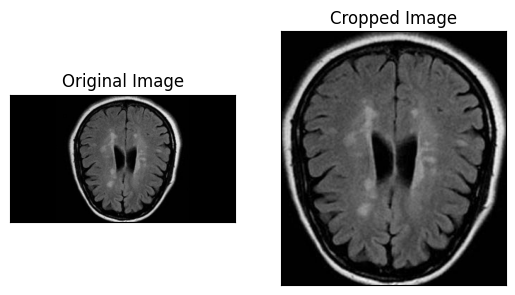

In [ ]:
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [ ]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-4:] == "yes/":
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/brain_tumor_detection/'
# augmented data (yes and no) contains both the original and the new generated examples
dataset_yes = dataset_path + 'yes/'
dataset_no = dataset_path + 'no/'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X, y = load_data([dataset_yes, dataset_no], (IMG_WIDTH, IMG_HEIGHT))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/brain_tumor_detection/yes/
y665.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y614.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y504.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y580.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y816.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y958.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y418.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y861.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y268.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y304.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y26.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y759.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y641.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y802.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y732.jpg
/content/drive/MyDrive/brain_tumor_detection/yes/
y316.jpg
/conte

In [ ]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2100
number of development examples = 450
number of test examples = 450
X_train shape: (2100, 240, 240, 3)
Y_train shape: (2100, 1)
X_val (dev) shape: (450, 240, 240, 3)
Y_val (dev) shape: (450, 1)
X_test shape: (450, 240, 240, 3)
Y_test shape: (450, 1)


In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
      
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/brain_tumor_detection/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
filepath='/content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-{epoch:02d}-{val_accuracy:.2f}.model'
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.5990
Epoch 1: val_accuracy improved from -inf to 0.59111, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-01-0.59.model


66/66 [==============================] - 141s 2s/step - loss: 0.9897 - accuracy: 0.5990 - val_loss: 0.6483 - val_accuracy: 0.5911
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7667
Epoch 2: val_accuracy improved from 0.59111 to 0.61333, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-02-0.61.model


66/66 [==============================] - 138s 2s/step - loss: 0.4927 - accuracy: 0.7667 - val_loss: 0.6028 - val_accuracy: 0.6133
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8233
Epoch 3: val_accuracy improved from 0.61333 to 0.67778, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-03-0.68.model


66/66 [==============================] - 140s 2s/step - loss: 0.4048 - accuracy: 0.8233 - val_loss: 0.5268 - val_accuracy: 0.6778
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8329
Epoch 4: val_accuracy improved from 0.67778 to 0.69333, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-04-0.69.model


66/66 [==============================] - 142s 2s/step - loss: 0.3714 - accuracy: 0.8329 - val_loss: 0.5706 - val_accuracy: 0.6933
Epoch 5/50
66/66 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8662
Epoch 5: val_accuracy improved from 0.69333 to 0.88667, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-05-0.89.model


66/66 [==============================] - 139s 2s/step - loss: 0.3174 - accuracy: 0.8662 - val_loss: 0.3165 - val_accuracy: 0.8867
Epoch 6/50
66/66 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.8857
Epoch 6: val_accuracy did not improve from 0.88667
66/66 [==============================] - 138s 2s/step - loss: 0.2783 - accuracy: 0.8857 - val_loss: 0.4622 - val_accuracy: 0.7533
Epoch 7/50
66/66 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9024
Epoch 7: val_accuracy improved from 0.88667 to 0.92444, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-07-0.92.model


66/66 [==============================] - 140s 2s/step - loss: 0.2430 - accuracy: 0.9024 - val_loss: 0.2448 - val_accuracy: 0.9244
Epoch 8/50
66/66 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8567
Epoch 8: val_accuracy did not improve from 0.92444
66/66 [==============================] - 138s 2s/step - loss: 0.3156 - accuracy: 0.8567 - val_loss: 0.2570 - val_accuracy: 0.9022
Epoch 9/50
66/66 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9152
Epoch 9: val_accuracy did not improve from 0.92444
66/66 [==============================] - 138s 2s/step - loss: 0.2119 - accuracy: 0.9152 - val_loss: 0.2551 - val_accuracy: 0.9000
Epoch 10/50
66/66 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9157
Epoch 10: val_accuracy did not improve from 0.92444
66/66 [==============================] - 138s 2s/step - loss: 0.2135 - accuracy: 0.9157 - val_loss: 0.2017 - val_accuracy: 0.9222
Epoch 11/50
66/66 [========================

66/66 [==============================] - 140s 2s/step - loss: 0.1647 - accuracy: 0.9443 - val_loss: 0.1962 - val_accuracy: 0.9311
Epoch 13/50
66/66 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9505
Epoch 13: val_accuracy did not improve from 0.93111
66/66 [==============================] - 141s 2s/step - loss: 0.1466 - accuracy: 0.9505 - val_loss: 0.1848 - val_accuracy: 0.9267
Epoch 14/50
66/66 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9538
Epoch 14: val_accuracy did not improve from 0.93111
66/66 [==============================] - 140s 2s/step - loss: 0.1403 - accuracy: 0.9538 - val_loss: 0.1990 - val_accuracy: 0.9267
Epoch 15/50
66/66 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9629
Epoch 15: val_accuracy improved from 0.93111 to 0.93778, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-15-0.94.model


66/66 [==============================] - 140s 2s/step - loss: 0.1243 - accuracy: 0.9629 - val_loss: 0.1775 - val_accuracy: 0.9378
Epoch 16/50
66/66 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9667
Epoch 16: val_accuracy did not improve from 0.93778
66/66 [==============================] - 139s 2s/step - loss: 0.1117 - accuracy: 0.9667 - val_loss: 0.2637 - val_accuracy: 0.8978
Epoch 17/50
66/66 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9600
Epoch 17: val_accuracy did not improve from 0.93778
66/66 [==============================] - 138s 2s/step - loss: 0.1248 - accuracy: 0.9600 - val_loss: 0.2806 - val_accuracy: 0.8844
Epoch 18/50
66/66 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9710
Epoch 18: val_accuracy improved from 0.93778 to 0.94444, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-18-0.94.model


66/66 [==============================] - 140s 2s/step - loss: 0.1079 - accuracy: 0.9710 - val_loss: 0.1522 - val_accuracy: 0.9444
Epoch 19/50
66/66 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9714
Epoch 19: val_accuracy did not improve from 0.94444
66/66 [==============================] - 139s 2s/step - loss: 0.0981 - accuracy: 0.9714 - val_loss: 0.4459 - val_accuracy: 0.8311
Epoch 20/50
66/66 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9829
Epoch 20: val_accuracy did not improve from 0.94444
66/66 [==============================] - 139s 2s/step - loss: 0.0799 - accuracy: 0.9829 - val_loss: 0.2273 - val_accuracy: 0.8933
Epoch 21/50
66/66 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9876
Epoch 21: val_accuracy improved from 0.94444 to 0.95333, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-21-0.95.model


66/66 [==============================] - 139s 2s/step - loss: 0.0700 - accuracy: 0.9876 - val_loss: 0.1169 - val_accuracy: 0.9533
Epoch 22/50
66/66 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9871
Epoch 22: val_accuracy did not improve from 0.95333
66/66 [==============================] - 139s 2s/step - loss: 0.0668 - accuracy: 0.9871 - val_loss: 0.1425 - val_accuracy: 0.9489
Epoch 23/50
66/66 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9771
Epoch 23: val_accuracy did not improve from 0.95333
66/66 [==============================] - 139s 2s/step - loss: 0.0854 - accuracy: 0.9771 - val_loss: 0.1329 - val_accuracy: 0.9400
Epoch 24/50
66/66 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9795
Epoch 24: val_accuracy did not improve from 0.95333
66/66 [==============================] - 141s 2s/step - loss: 0.0762 - accuracy: 0.9795 - val_loss: 0.2510 - val_accuracy: 0.8867
Epoch 25/50
66/66 [====================

66/66 [==============================] - 141s 2s/step - loss: 0.0602 - accuracy: 0.9876 - val_loss: 0.1189 - val_accuracy: 0.9600
Epoch 26/50
66/66 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9919
Epoch 26: val_accuracy did not improve from 0.96000
66/66 [==============================] - 140s 2s/step - loss: 0.0503 - accuracy: 0.9919 - val_loss: 0.1255 - val_accuracy: 0.9556
Epoch 27/50
66/66 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9924
Epoch 27: val_accuracy improved from 0.96000 to 0.96222, saving model to /content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-27-0.96.model


66/66 [==============================] - 140s 2s/step - loss: 0.0483 - accuracy: 0.9924 - val_loss: 0.1251 - val_accuracy: 0.9622
Epoch 28/50
66/66 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9919
Epoch 28: val_accuracy did not improve from 0.96222
66/66 [==============================] - 139s 2s/step - loss: 0.0523 - accuracy: 0.9919 - val_loss: 0.1291 - val_accuracy: 0.9444
Epoch 29/50
66/66 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9943
Epoch 29: val_accuracy did not improve from 0.96222
66/66 [==============================] - 139s 2s/step - loss: 0.0389 - accuracy: 0.9943 - val_loss: 0.1108 - val_accuracy: 0.9556
Epoch 30/50
66/66 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9981
Epoch 30: val_accuracy did not improve from 0.96222
66/66 [==============================] - 139s 2s/step - loss: 0.0345 - accuracy: 0.9981 - val_loss: 0.1131 - val_accuracy: 0.9578
Epoch 31/50
66/66 [====================

66/66 [==============================] - 141s 2s/step - loss: 0.0281 - accuracy: 0.9990 - val_loss: 0.1108 - val_accuracy: 0.9644
Epoch 34/50
66/66 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9990
Epoch 34: val_accuracy did not improve from 0.96444
66/66 [==============================] - 140s 2s/step - loss: 0.0256 - accuracy: 0.9990 - val_loss: 0.1013 - val_accuracy: 0.9600
Epoch 35/50
66/66 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9971
Epoch 35: val_accuracy did not improve from 0.96444
66/66 [==============================] - 140s 2s/step - loss: 0.0334 - accuracy: 0.9971 - val_loss: 0.2221 - val_accuracy: 0.9200
Epoch 36/50
66/66 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9962
Epoch 36: val_accuracy did not improve from 0.96444
66/66 [==============================] - 139s 2s/step - loss: 0.0279 - accuracy: 0.9962 - val_loss: 0.1011 - val_accuracy: 0.9644
Epoch 37/50
66/66 [====================

66/66 [==============================] - 140s 2s/step - loss: 0.0162 - accuracy: 0.9990 - val_loss: 0.0923 - val_accuracy: 0.9689
Epoch 41/50
66/66 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 0.96889
66/66 [==============================] - 140s 2s/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.1407 - val_accuracy: 0.9622
Epoch 42/50
66/66 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9995
Epoch 42: val_accuracy did not improve from 0.96889
66/66 [==============================] - 140s 2s/step - loss: 0.0135 - accuracy: 0.9995 - val_loss: 0.1035 - val_accuracy: 0.9600
Epoch 43/50
66/66 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9990
Epoch 43: val_accuracy did not improve from 0.96889
66/66 [==============================] - 140s 2s/step - loss: 0.0135 - accuracy: 0.9990 - val_loss: 0.0965 - val_accuracy: 0.9622
Epoch 44/50
66/66 [====================

In [ ]:
history = model.history.history

In [ ]:
history

{'loss': [0.9897395968437195,
  0.4926849603652954,
  0.4047532379627228,
  0.37135130167007446,
  0.31744757294654846,
  0.278298556804657,
  0.24301964044570923,
  0.31559398770332336,
  0.21193057298660278,
  0.2135356217622757,
  0.1836821287870407,
  0.16465918719768524,
  0.14661502838134766,
  0.14025704562664032,
  0.12427213788032532,
  0.11165300011634827,
  0.12476778775453568,
  0.10789129137992859,
  0.09814197570085526,
  0.07988864183425903,
  0.0699852779507637,
  0.06681705266237259,
  0.08537303656339645,
  0.0762392058968544,
  0.060206323862075806,
  0.0502738356590271,
  0.04832913726568222,
  0.052259400486946106,
  0.03892793878912926,
  0.03448972478508949,
  0.03301355987787247,
  0.02813138999044895,
  0.028061095625162125,
  0.025608763098716736,
  0.033408112823963165,
  0.027911439538002014,
  0.03122408129274845,
  0.020862240344285965,
  0.016505042091012,
  0.01623166911303997,
  0.016451822593808174,
  0.013505656272172928,
  0.013453462161123753,
  0.0

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

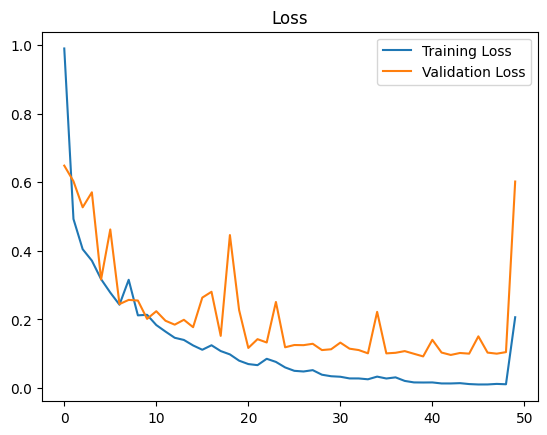

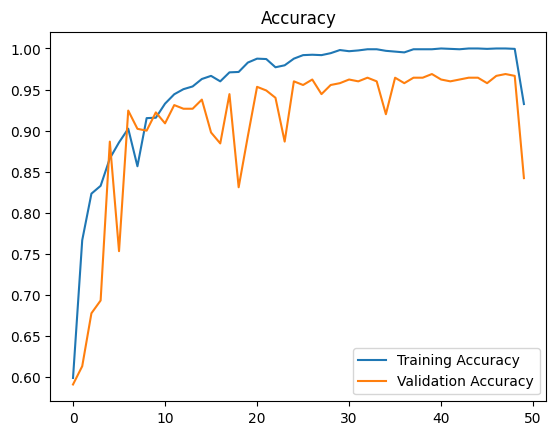

In [ ]:
plot_metrics(history) 

In [ ]:
best_model = load_model(filepath='/content/drive/MyDrive/brain_tumor_detection/ModelCheckpoint/Checkpoint-40-0.97.model')
loss, acc = best_model.evaluate(X_test, y_test)
print(f"Test Loss = {loss}")
print(f"Test Accuracy = {acc}")

15/15 [==============================] - 8s 480ms/step - loss: 0.1285 - accuracy: 0.9511
Test Loss = 0.12851554155349731
Test Accuracy = 0.9511111378669739


In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [ ]:
#F1 score for the best model on the testing data:

y_test_prob = best_model.predict(X_test)

15/15 [==============================] - 8s 544ms/step


In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9523809523809524


In [ ]:
#F1 score for the best model on the validation data:
y_val_prob = best_model.predict(X_val)

15/15 [==============================] - 7s 485ms/step


In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.968181818181818


            Validation set    Test set
Accuracy         93%            95% 
F1 score        0.93           0.95

In [ ]:
# Import necessary libraries
import numpy as np
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.applications.imagenet_utils import preprocess_input

# Load pre-trained CNN model
json_file = open('/content/drive/MyDrive/brain_tumor_detection/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(loaded_model_json)
model.load_weights('/content/drive/MyDrive/brain_tumor_detection/model.h5')



In [ ]:
# Load test data
def predict(img):
  test_image = load_img(img, target_size=(240, 240))
  plt.imshow(test_image)
  X = np.array(test_image)
  X = np.expand_dims(X, axis=0)
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  test_image = preprocess_input(test_image)

# Make prediction
  prediction = model.predict(test_image)

  if prediction > 0.5:
    print('TUMOR FOUND')
  else:
    print('NO TUMOR FOUND')


1/1 [==============================] - 0s 327ms/step
NO TUMOR FOUND


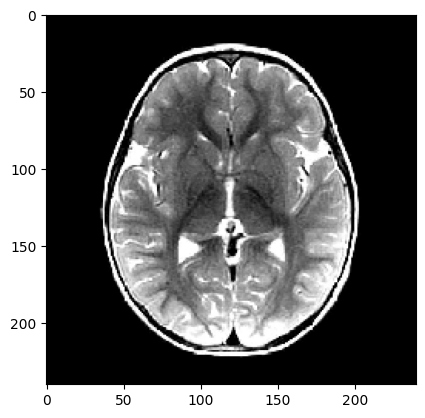

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/no/no0.jpg')

1/1 [==============================] - 0s 39ms/step
TUMOR FOUND


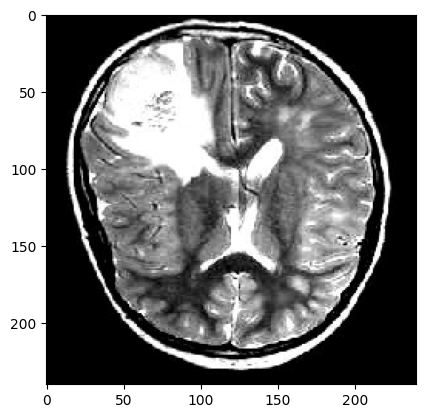

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/yes/y0.jpg')

1/1 [==============================] - 0s 37ms/step
TUMOR FOUND


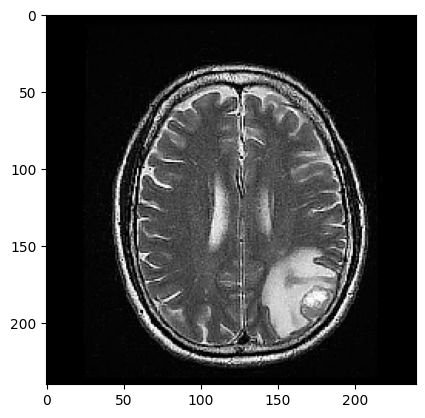

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/yes/y1125.jpg')

1/1 [==============================] - 0s 41ms/step
TUMOR FOUND


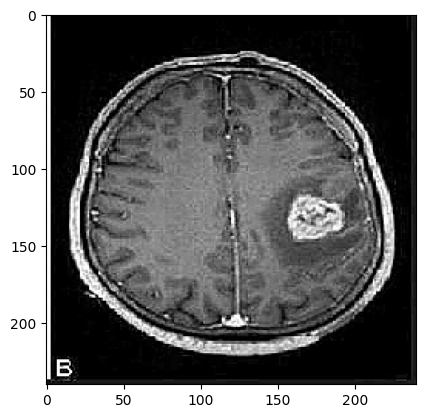

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/yes/y1194.jpg')

1/1 [==============================] - 0s 35ms/step
NO TUMOR FOUND


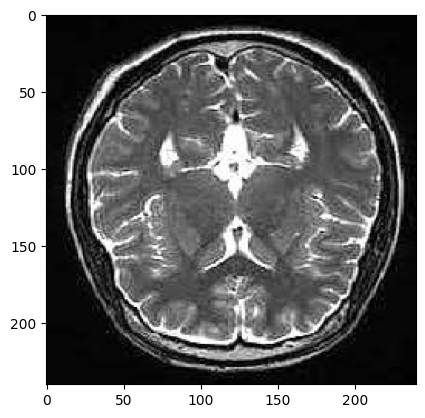

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/no/no1413.jpg')

1/1 [==============================] - 0s 42ms/step
NO TUMOR FOUND


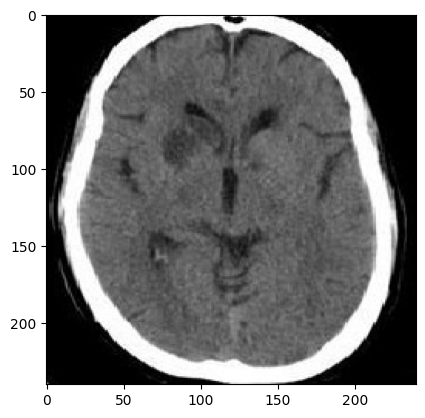

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/no/no548.jpg')

1/1 [==============================] - 0s 36ms/step
NO TUMOR FOUND


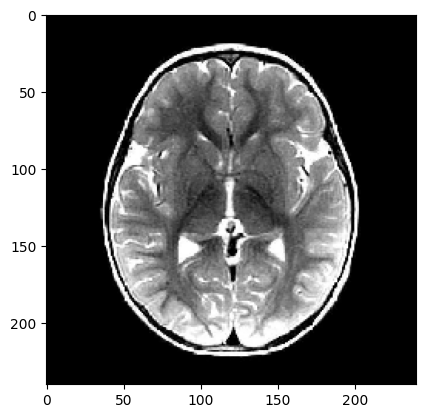

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/no/no424.jpg')

1/1 [==============================] - 0s 37ms/step
NO TUMOR FOUND


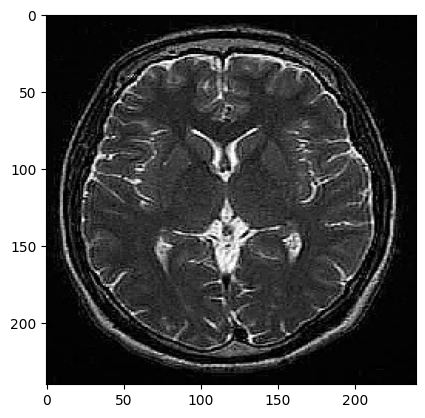

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/no/no354.jpg')

1/1 [==============================] - 0s 36ms/step
TUMOR FOUND


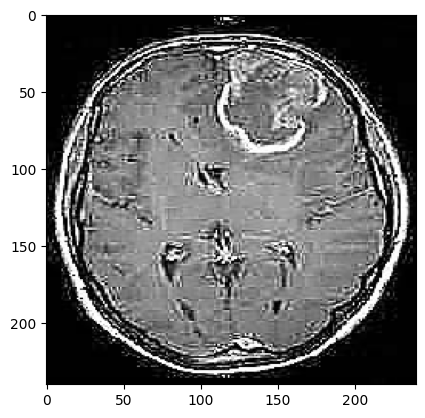

In [ ]:
predict('/content/drive/MyDrive/brain_tumor_detection/yes/y548.jpg')